# ESG銘柄でのポートフォリオ構築
### ESG銘柄の選定
Yahooファイナンスの"Sustainability"ページからESGスコアと製品関与情報を取得する

- ESG Risk Score: 数字が小さいほどESGリスクが小さい（＝ESG銘柄として適格）
- Product Involvement : 特定の（好ましくない）製品に関与しているかどうか（アルコール飲料、成人向けエンターテイメント、ギャンブル、タバコなど）

→ESGリスクスコアが同業平均（Peer avg）より低く、Product Involvementが全て「No」の182銘柄をESG銘柄として使用した

![チャート](./finance.yahoo.com_quote_XOM_sustainability_p=XOM.png)


### ESG銘柄でのポートフォリオ最適化
182銘柄で最適化→上位100銘柄で再度最適化によりポートフォリオを構築
→ESG銘柄でもベンチマークに追従するポートフォリオを構築可能

![チャート](./sp500/esg-portfolio100_esg.png)

### ESG銘柄のリターン
ESGポートフォリと制約なしポートフォリオンの比較
![チャート](./esg_return.png)



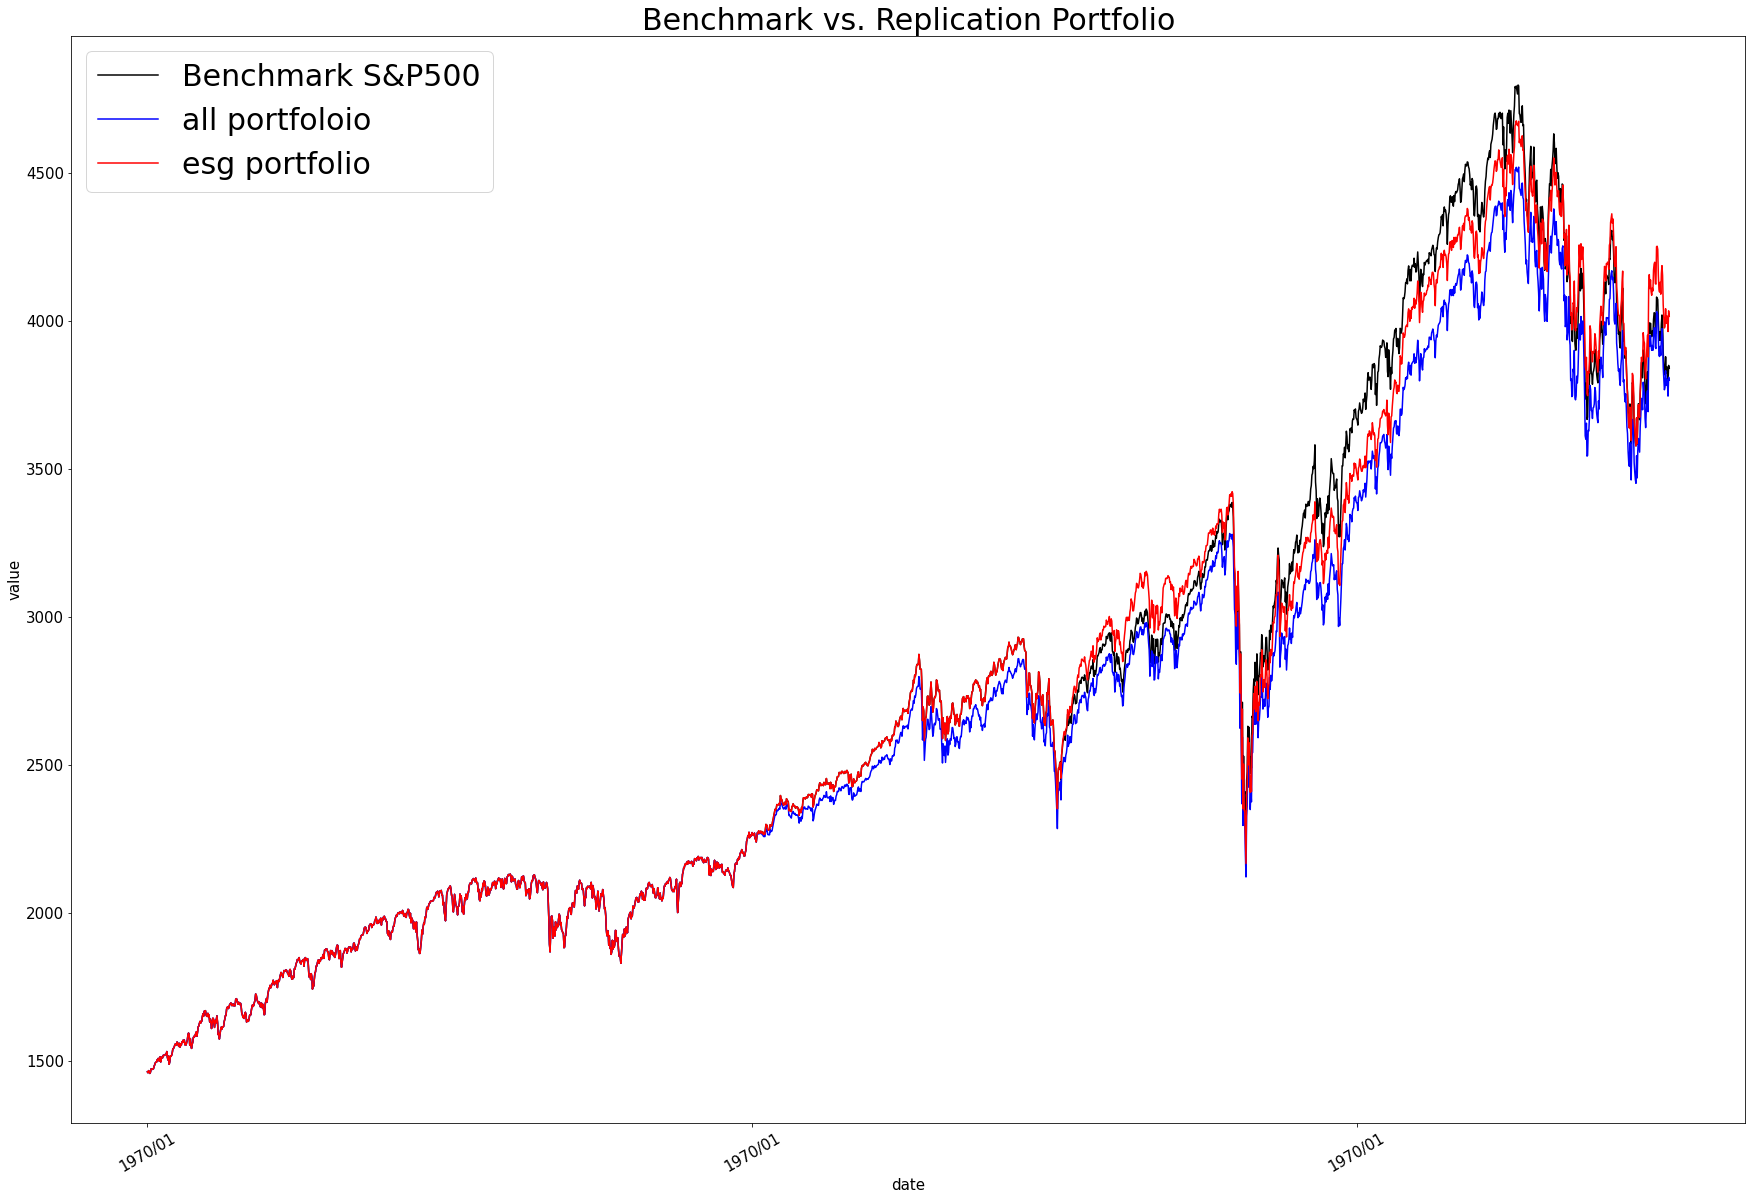

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

ganpon=100000
# fig = make_subplots(rows=2, cols=1)

Benchmark = pd.read_csv('./sp500/b2.csv')
di_full = pd.read_csv('./sp500/portfolio100.csv')
esg_port = pd.read_csv('./sp500/portfolio100_esg.csv')

fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(111)

#ベンチマーク
ax.plot(pd.to_datetime(Benchmark.index),Benchmark['Close'],c='k')
#フル1000銘柄
ax.plot(pd.to_datetime(di_full.index),di_full['Close'],c='b',linestyle="-")
#ESG銘柄
ax.plot(pd.to_datetime(esg_port.index),esg_port['Close'],c='r',linestyle="-")

ax.legend(labels=['Benchmark S&P500','all portfoloio','esg portfolio'],fontsize=30)
ax.set_xlabel('date', size=15)
ax.set_ylabel('value', size=15)
ax.set_title('Benchmark vs. Replication Portfolio', fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))

fig.savefig('esg_return.png')